# 1.数据的批量读取

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
#tensorflow提供的数据集的读取方法
import tensorflow.examples.tutorials.mnist.input_data as input_data

In [3]:
mnist=input_data.read_data_sets('MNIST_data/',one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


为什么要采用one-hot(读热码)编码？

1.将离散特征的取值扩展到欧式空间，离散特征的某个取值就对应欧式空间的某个点。

2.机器学习算法中，特征之间的距离的计算或相识度的常用计算方法都是基于欧式空间的。

3.将离散特征使用one-hot编码会让特征之间的距离计算更加合理。

# 2.模型构建

In [4]:
#重构建模（用函数）
def fcn_layer(inputs,   #输入数据
             input_dim, #输入神经元数量
             output_dim,#输出神经元数量
             activation=None):#激活函数
    W=tf.Variable(tf.truncated_normal([input_dim,output_dim],stddev=0.1),name='W')
    b=tf.Variable(tf.zeros([output_dim]),name='b')
    XWb=tf.matmul(inputs,W)+b
    if activation is None:
        outputs=XWb
    else:
        outputs=activation(XWb)
    return outputs

In [5]:
#构建输入层
#定义待输入数据的占位符 
x=tf.placeholder(tf.float32,[None,784],name="X")
y=tf.placeholder(tf.float32,[None,10],name="Y")

In [6]:
#构建隐含层1
H1NN=256
H2NN=64
H3NN=32
h1=fcn_layer(inputs=x,   #输入数据
             input_dim=784, #输入神经元数量
             output_dim=H1NN,#输出神经元数量
             activation=tf.nn.relu)

In [7]:
#构建隐含层2
h2=fcn_layer(inputs=h1,   #输入数据
             input_dim=H1NN, #输入神经元数量
             output_dim=H2NN,#输出神经元数量
             activation=tf.nn.relu)

In [8]:
#构建隐含层3
h3=fcn_layer(inputs=h2,   #输入数据
             input_dim=H2NN, #输入神经元数量
             output_dim=H3NN,#输出神经元数量
             activation=tf.nn.relu)

In [9]:
#构建输出层
forward=fcn_layer(inputs=h3,   #输入数据
             input_dim=H3NN, #输入神经元数量
             output_dim=10,#输出神经元数量
             activation=None)


In [10]:
#结果分类softmax将二分类延伸到多分类
pred=tf.nn.softmax(forward)

# 3.模型训练

In [11]:
train_epochs=40 #训练轮数
batch_size=50#单次训练样本的大小
total_batch=int(mnist.train.num_examples/batch_size)#每轮训练多少批次
learning_rate=0.01 #学习率
display_step=1#显示粒度

In [12]:
#定义交叉熵损失函数
# loss_function=tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred),reduction_indices=1))#结果出现nan
#tensorflow中提供了softmax_cross_entropy_with_logits函数，用于避免因为log(0)值为nan造成的数据不稳定。
loss_function=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=forward,labels=y))
#选择优化器
# optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_function)
optimizer=tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

In [13]:
#定义准确率
correct_prediction=tf.equal(tf.argmax(pred,1),tf.argmax(y,1))#得到一个bool值
#将bool值转化为浮点数，并计算平均值
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [14]:
#指定好已保存模型的文件路径
# save_step=5
ckpt_dir='./ckpt_dir/'

In [15]:
#声明完所有变量后，调用tf.train.Saver
saver=tf.train.Saver()

In [16]:
#声明会话，初始化变量
sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)

In [17]:
ckpt=tf.train.get_checkpoint_state(ckpt_dir)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess,ckpt.model_checkpoint_path)#从已保存的模型中读取参数
    print('Restore model from'+ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ./ckpt_dir/mnist_model.ckpt
Restore model from./ckpt_dir/mnist_model.ckpt


# 4.模型评估与应用

In [18]:
#完成训练后，在测试集上评估模型的准确率
accu_test=sess.run(accuracy,
                        feed_dict={x:mnist.test.images,y:mnist.test.labels})
print("Test Accuracy:",accu_test)

Test Accuracy: 0.9696


In [19]:
#由于pred预测结果是one-hot编码格式，所以需要转换为0~9数字
prediction_result=sess.run(tf.argmax(pred,1),feed_dict={x:mnist.test.images})
prediction_result[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [20]:
#定义输出错误分类的函数
def print_predict_errs(labels,prediction):
    count=0
    compare_lists=(prediction==np.argmax(labels,1))
    err_lists=[i for i in range(len(compare_lists)) if compare_lists[i]==False]
    for x in err_lists:
        print('index='+str(x)+
             '标签值=',np.argmax(labels[x]),
             '预测值=',prediction[x])
        count+=1
    print('总计:'+str(count))

In [21]:
print_predict_errs(labels=mnist.test.labels,prediction=prediction_result)

index=63标签值= 3 预测值= 2
index=149标签值= 2 预测值= 3
index=217标签值= 6 预测值= 2
index=247标签值= 4 预测值= 2
index=259标签值= 6 预测值= 0
index=266标签值= 8 预测值= 0
index=268标签值= 8 预测值= 2
index=321标签值= 2 预测值= 7
index=340标签值= 5 预测值= 3
index=359标签值= 9 预测值= 2
index=381标签值= 3 预测值= 7
index=417标签值= 9 预测值= 7
index=445标签值= 6 预测值= 0
index=449标签值= 3 预测值= 5
index=479标签值= 9 预测值= 2
index=495标签值= 8 预测值= 2
index=527标签值= 8 预测值= 2
index=582标签值= 8 预测值= 2
index=619标签值= 1 预测值= 2
index=684标签值= 7 预测值= 2
index=720标签值= 5 预测值= 8
index=761标签值= 8 预测值= 3
index=882标签值= 9 预测值= 4
index=885标签值= 6 预测值= 8
index=900标签值= 1 预测值= 2
index=947标签值= 8 预测值= 9
index=951标签值= 5 预测值= 2
index=956标签值= 1 预测值= 3
index=965标签值= 6 预测值= 0
index=999标签值= 9 预测值= 3
index=1014标签值= 6 预测值= 5
index=1032标签值= 5 预测值= 2
index=1039标签值= 7 预测值= 1
index=1068标签值= 8 预测值= 2
index=1082标签值= 5 预测值= 3
index=1107标签值= 9 预测值= 3
index=1112标签值= 4 预测值= 2
index=1156标签值= 7 预测值= 2
index=1166标签值= 3 预测值= 2
index=1178标签值= 4 预测值= 0
index=1194标签值= 7 预测值= 2
index=1226标签值= 7 预测值= 2
index=1232标签值= 9 预测值= 4

In [22]:
#定义可视化函数
def plot_image_labels_prediction(images,#图像列表
                                labels,#标签列表
                                prediction,#预测值列表
                                index,#从第index个图像开始显示
                                num=10):#缺省一次显示10幅
    fig=plt.gcf()   #获取当前图标，Get Current Figure
    fig.set_size_inches(10,12)  #1英寸=2.54cm
    if num>25:
        num=25         #最多显示25个子图
    for i in range(0,num):
        ax=plt.subplot(5,5,i+1)
        ax.imshow(np.reshape(images[index],(28,28)),cmap='binary' )#显示第index个图像
        title='label='+str(np.argmax(labels[index]))#构建该图上要显示的title信息
        if len(prediction)>0:
            title+=',predict'+str(prediction[index])
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])#不显示坐标轴
        ax.set_yticks([])
        index+=1
    plt.show()
        

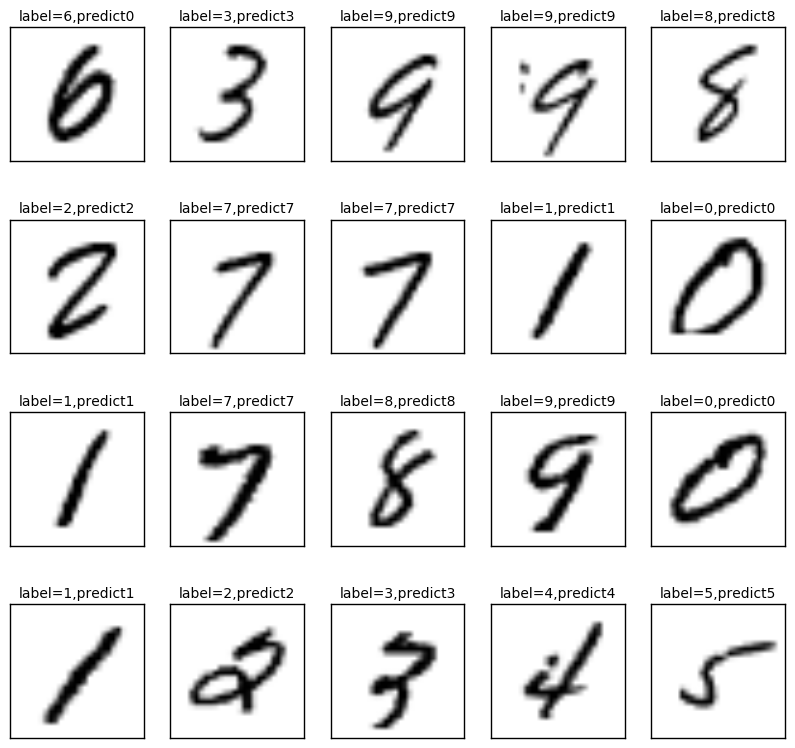

In [23]:
plot_image_labels_prediction(mnist.test.images,
                             mnist.test.labels,
                             prediction_result,
                                9888,
                                20)